In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM

# Correlation maps

```MIfile``` class can be used as an input for ```CorrMaps``` class, which computes intensity correlation maps.
Intensity correlations are defined as in S. Aime et al, *Phys. Rev. Lett.* (2021):

$$
c_I(\vec{x}, t, \tau) = \frac{\langle I(\vec{x}, t)I(\vec{x}, t+\tau) \rangle}{\langle I(\vec{x}, t)\rangle\langle I(\vec{x}, t+\tau) \rangle} - 1
$$

where $I$ is the image intensity and $\vec{x}, t, \tau$ denote pixel position, time and time lag, respectively. In DSH, the average $\langle \ddots \rangle$ is computed on groups of nearby pixels to retain spatio-temporal resolution. 

### Kernel

In particular, DSH uses a customizable kernel $K(d\vec{x})$ to optimize the spatial resolution. This kernel is then used to compute averages of any scalar field (say, $y(\vec{x})$) as follows:

$$
\langle y(\vec{x}) \rangle = \frac{\sum\limits_{i=-L_1}^{L_1}\sum\limits_{j=-L_2}^{L_2} y(\vec{x} + \vec{x}_{ij}) K(\vec{x}_{ij})}{\sum\limits_{i=-L_1}^{L_1}\sum\limits_{j=-L_2}^{L_2} K(\vec{x}_{ij})}
$$

This operation is performed using ```scipy.signal.convolve2d```, which also takes care of the boundary conditions needed to compute $\langle y(\vec{x}) \rangle$ when $\vec{x}$ is closer to the image boundaries than either kernel size.

A narrower kernel provides better spatial resolution, but poorer statistics, thereby larger fluctuations on the correlation values. For that reason, the size and shape of the kernel needs to be fine tuned. 
A constant kernel would correspond to the *standard* average on regions of interest (ROIs) of size $(2L_1+1)(2L_2+1)$, whereas a Gaussian kernel is often a more optimal choice. DSH allows one to choose both shape and size of the kernek using the ```DSH.Kernel``` object, which can be initialized using ```Kernel.initialize(shape, kernel_type, params={}, n_dim=2, padding=False, convolve_kwargs={})```, 
where:
- ```shape``` (```int``` or n-dimensional list of ```int```) is the shape of the output kernel matrix: $(2L_1+1,2L_2+1)$, or $2L+1$ if $L_1=L_2=L$. It is best to choose odd numbers
- ```kernel_type``` (```str```) is the kernel type. For the moment the only supported types are ```'flat'```, a uniform kernel, and ```'Gauss'```, a Gaussian kernel, which requires specification of ```'sigma'``` (```float``` or n-dimensional tuple), the Gaussian standard deviation. Eventual additional parameters are specified in the ```params``` variable (```dict```).
- ```n_dim``` (```int```) is the number of dimensions
- ```padding``` (```bool```): if ```True```, the input images will be padded with zeroes such that the output correlation maps will have the same shape as the input images. Otherwise, the correlation maps will have the margins trimmed of an amount equal to the kernel size.
- ```convolve_kwargs``` is a ```dict``` containing eventual extra keywords that will be passed to ```scipy.signal.convolve2d```

<Kernel [2D Gauss], 11x9, s=(2.5;1.5)>


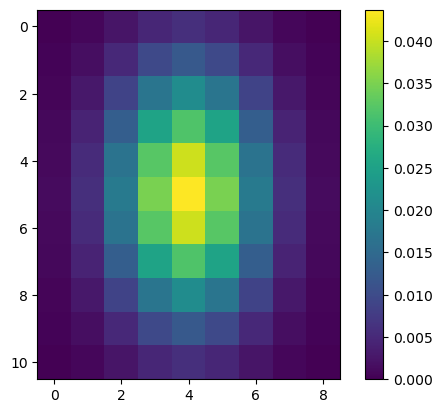

In [2]:
KernelSpecs = DSH.Kernel.Kernel()
KernelSpecs.Initialize(shape=(11,9), kernel_type='Gauss', params={'sigma':[2.5, 1.5]}, padding=True)
print(KernelSpecs)
plt.imshow(KernelSpecs.ToMatrix(), vmin=0)
plt.colorbar()

The ```DSH.Kernel``` object can be tested by convolving it with a test image, using ```Kernel.ConvolveImage(imgInput)```:

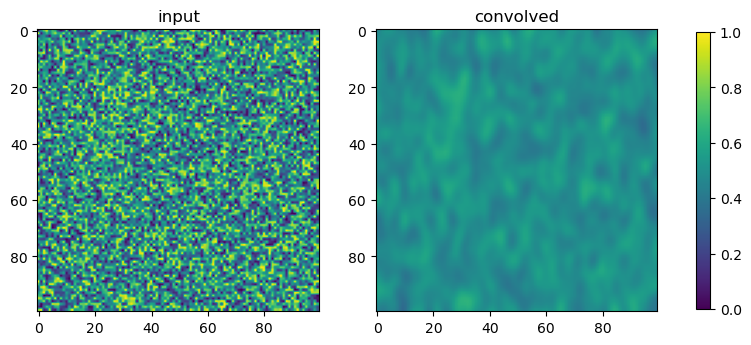

In [3]:
imgInput = np.random.rand(100, 100)
imgConvolved = KernelSpecs.ConvolveImage(imgInput)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title('input')
ax1.imshow(imgInput, vmin=0, vmax=1)
ax2.set_title('convolved')
cbar = ax2.imshow(imgConvolved, vmin=0, vmax=1)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.6)

### Normalization

Defined as above, the intensity correlation decays from an initial value $c_I(\tau=0)=\langle I^2 \rangle / \langle I \rangle^2 - 1$ to zero, as for two uncorrelated images $\langle I_1 I_2 \rangle=\langle I_1 \rangle\langle I_2 \rangle$.
For a speckle pattern, the initial value $c_I(\tau=0)$, which in the following we will call the image contrast, can take different values between 0 and 1, with larger values reflecting more contrasted speckle patterns, depending on imaging conditions such as the speckle size and the image exposure time. In addition, for narrow kernels, $c_I(\tau=0)$ typically exhibits statistical fluctuations in time.

To obtain a more robust indicator of the microscopic dynamics, DSH further normalizes the correlation function by the image contrast, as illustrated in A. Duri et al, *Phys. Rev. E* (2005):

$$
\tilde c_I(\vec{x}, t, \tau) = 2 \frac{c_I(\vec{x}, t, \tau)}{c_I(\vec{x}, t, 0)+c_I(\vec{x}, t+\tau, 0)}
$$

DSH correlation maps use this normalized correlator, which decays from 1 to 0 by construction. For crosscheck verifications it is sometimes useful to have the actual value of $c_I$, in addition to the normalized version $\tilde c_I$. For this reason, DSH also saves the image contrast as $\tau=0$ (```d0```) correlation. No map is saved for $\tilde c_I(\tau=0)$, as it would be 1 by construction.

Note that eventual nonidealities such as camera noise or stray light may produce deviations at both $\tau \rightarrow 0$ and $\tau \rightarrow \infty$, that are discussed in S. Aime and L. Cipelletti, *Soft Matter* (2018).

### Computing correlation maps

We initialize a ```CorrMaps``` class like this:

```python
corrmap = CM.CorrMaps(MIin, outFolder, lagList, KernelSpecs, imgRange=None, cropROI=None)
```

where:
- ```MIin``` is the input ```MIfile``` class
- ```outFolder``` (```str```) is the output folder where correlation maps will be saved
- ```lagList``` is a list of lagtimes (```int```, in image units, independent on the step specified in ```imgRange```). One correlation map will be computer for each lagtime
- ```KernelSpecs``` is a ```DSH.Kernel``` object containing the parameters for local averaging.
- ```imgRange``` is a list of 3 ```int``` of the form ```[z_min, z_max, z_step]```.
- ```cropROI``` contains ROI specs in the same form as the one specified for MIfile class

To initialize ```CorrMaps```, let's first load a ```MIfile``` object (see tutorial 1 for details)

In [4]:
froot = os.path.join(os.path.dirname(MI.__file__), 'test')
fname = os.path.join(froot, 'MIfile.dat')
metadata_fname = os.path.join(froot, 'metadata.ini')
mi_file = MI.MIfile(fname, metadata_fname)
test_ROI = [200, 100, -1, 50]

Now let's initialize ```CorrMaps``` using this ```MIfile```:

In [5]:
corrmap = CM.CorrMaps(mi_file, froot, [1], KernelSpecs, imgRange=None, cropROI=test_ROI)

Once again, initialization only computes analysis parameters. To actually compute the correlation maps we need to call:

```python
cmap_list = corrmap.Compute(silent=True, return_maps=False)
```

Correlation maps will only returned if argument ```return_maps``` is set to ```True```. However, be aware that this may lead to heavy memory usage, and that no memory check will be done. When ```return_maps==False```, ```None``` will be returned. For testing purposes, we compute correlation maps on a small subset of the MIfile, and we return the output

In [6]:
cmap_list = corrmap.Compute(silent=False, return_maps=True)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
Procedure completed in 0.0 seconds!


check out one random frame from each correlation map:

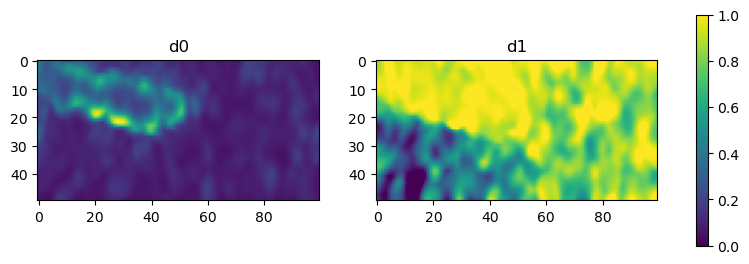

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
tidx = 0
lagidx = 1
ax1.set_title('d0')
ax1.imshow(cmap_list[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(cmap_list[lagidx][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

Here, the left panel shows the image contrast $c_I(\vec{x},\tau=0)$, which is computed even though lagtime 0 was not included in ```lagList```. The right panel shows the normalized correlation map $\tilde c_I(\vec{x},\tau=1)$.

Once again, details about the CorrMap class instance can be printed to output by simply doing:

In [8]:
print(corrmap)


|-----------------|
| CorrMaps class: |
|-----------------+---------------
| MI input        : <MIfile: 0+2x200x300x1 bytes>
| output folder   : c:\Users\stefa\Documents\GitHub\DSHpy\DSH\test
| lag times (01)  : [1]
| image range     : [0, 2, 1]
| crop ROI        : [200, 100, 100, 50]
| Kernel          : <Kernel [2D Gauss], 11x9, s=(2.5;1.5)>
|-----------------+---------------


If we don't use padding the output is similar, just trimmed at the edges. The computation may be slightly faster.

In [9]:
KernelSpecs.SetPadding(False)
corrmap_nopad = CM.CorrMaps(mi_file, froot, [1], KernelSpecs, imgRange=None, cropROI=test_ROI)
cmap_list_nopad = corrmap_nopad.Compute(silent=False, return_maps=True)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
Procedure completed in 0.0 seconds!


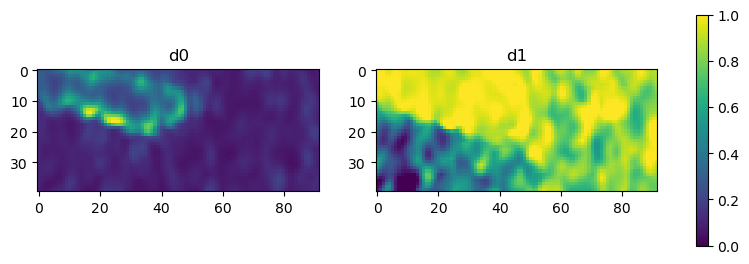

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title('d0')
ax1.imshow(cmap_list_nopad[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(cmap_list_nopad[lagidx][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

To check that everywhere away from the boundary the two methods are the same we compute the difference:

In [11]:
abs_diff = np.absolute(np.subtract(cmap_list[1][tidx, 5:-5, 4:-4],cmap_list_nopad[1][tidx]))
print('{0}/{1} pixels above numerical noise (max difference: {2})'.format(np.sum(abs_diff>0), np.prod(abs_diff.shape), np.max(abs_diff)))
if np.any(np.sum(abs_diff>0)):
    plt.imshow(abs_diff)
    plt.colorbar()

0/3680 pixels above numerical noise (max difference: 0.0)
